In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. LOADING THE DATA 

In [23]:
PATH = "human+activity+recognition+using+smartphones/UCI HAR Dataset/"
features_path = PATH + "features.txt"
activity_labels_path = PATH + "activity_labels.txt"
X_train_path = PATH + "train/X_train.txt"
y_train_path = PATH + "train/y_train.txt"
X_test_path = PATH + "test/X_test.txt"
y_test_path = PATH + "test/y_test.txt"


# Load feature names, This appends the column index to any duplicate names.
features_df = pd.read_csv(features_path, sep="\s+", header=None, names=["idx", "feature"])
feature_names = features_df["feature"].tolist()


# this appends the column index to any duplicate names.
features_df["feature"] = features_df["feature"].astype(str) + "_" + features_df.index.astype(str)
feature_names = features_df["feature"].tolist()


# Load activity labels (mapping IDs 1-6 to string names)
activity_labels_df = pd.read_csv(activity_labels_path, sep="\s+", header=None, names=["id", "activity"])
activity_map = dict(zip(activity_labels_df["id"], activity_labels_df["activity"]))

# Load train/test sets
X_train = pd.read_csv(X_train_path, sep="\s+", header=None, names=feature_names)
y_train = pd.read_csv(y_train_path, sep="\s+", header=None, names=["Activity"])
X_test = pd.read_csv(X_test_path, sep="\s+", header=None, names=feature_names)
y_test = pd.read_csv(y_test_path, sep="\s+", header=None, names=["Activity"])

# Map the activity IDs to their names
y_train["Activity"] = y_train["Activity"].map(activity_map)
y_test["Activity"] = y_test["Activity"].map(activity_map)


# 2. CONVERT MULTI-CLASS TO BINARY 

In [24]:
def to_binary_label(activity):
    if activity in ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"]:
        return 1  # Active
    else:
        return 0  # Inactive

y_train["Binary"] = y_train["Activity"].apply(to_binary_label)
y_test["Binary"] = y_test["Activity"].apply(to_binary_label)

# 3. TRAINING SVM MODELS 

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# --- Initialize SVM models with different kernels ---
svm_linear = SVC(kernel="linear", random_state=42)
svm_poly = SVC(kernel="poly", degree=3, random_state=42)  # Polynomial kernel with degree=3
svm_rbf = SVC(kernel="rbf", random_state=42)  # RBF kernel

# --- Train the models ---
svm_linear.fit(X_train, y_train["Binary"])
svm_poly.fit(X_train, y_train["Binary"])
svm_rbf.fit(X_train, y_train["Binary"])

# --- Make predictions ---
y_pred_linear = svm_linear.predict(X_test)
y_pred_poly = svm_poly.predict(X_test)
y_pred_rbf = svm_rbf.predict(X_test)

# --- Evaluate models ---
acc_linear = accuracy_score(y_test["Binary"], y_pred_linear)
acc_poly = accuracy_score(y_test["Binary"], y_pred_poly)
acc_rbf = accuracy_score(y_test["Binary"], y_pred_rbf)

# --- Print results ---
print(f"Linear Kernel Accuracy: {acc_linear:.4f}")
print(f"Polynomial Kernel Accuracy: {acc_poly:.4f}")
print(f"RBF Kernel Accuracy: {acc_rbf:.4f}")


Linear Kernel Accuracy: 1.0000
Polynomial Kernel Accuracy: 0.9997
RBF Kernel Accuracy: 0.9997


# 4. HYPERPARAMETER TUNING

In [26]:
from sklearn.model_selection import GridSearchCV

# --- Define parameter grids for each kernel ---
param_grid = {
    'linear': {'C': [0.1, 1, 10, 100]},
    'poly': {'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
    'rbf': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.01, 0.1, 1]}
}

# --- Run GridSearchCV for each kernel ---
best_params = {}
best_scores = {}

for kernel in ['linear', 'poly', 'rbf']:
    print(f"🔍 Tuning {kernel} kernel...")
    
    # Create an SVM model with the current kernel
    model = SVC(kernel=kernel)
    
    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(model, param_grid[kernel], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train["Binary"])
    
    # Store best parameters and accuracy
    best_params[kernel] = grid_search.best_params_
    best_scores[kernel] = grid_search.best_score_
    
    print(f"✅ Best params for {kernel}: {grid_search.best_params_}")
    print(f"📊 Best cross-validation accuracy: {grid_search.best_score_:.4f}\n")

# --- Print Final Best Parameters ---
print("🏆 Best Parameters for Each Kernel:")
print(best_params)

🔍 Tuning linear kernel...
✅ Best params for linear: {'C': 0.1}
📊 Best cross-validation accuracy: 0.9996

🔍 Tuning poly kernel...
✅ Best params for poly: {'C': 0.1, 'degree': 4}
📊 Best cross-validation accuracy: 0.9995

🔍 Tuning rbf kernel...
✅ Best params for rbf: {'C': 1, 'gamma': 0.01}
📊 Best cross-validation accuracy: 0.9996

🏆 Best Parameters for Each Kernel:
{'linear': {'C': 0.1}, 'poly': {'C': 0.1, 'degree': 4}, 'rbf': {'C': 1, 'gamma': 0.01}}


# 5.EVALUATE AND INTERPREAT RESULTS

## Confusion Matrix

In [27]:
y_test["Binary"] = y_test["Activity"].apply(to_binary_label)
y_test_binary = y_test["Binary"].astype(int)

y_pred = grid_search.predict(X_test)
y_pred = y_pred.astype(int)


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_binary, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[1558    2]
 [   0 1387]]


## Classification Metrics

In [29]:
from sklearn.metrics import classification_report

# Print detailed classification metrics (precision, recall, F1-score)
print("Classification Report:")
print(classification_report(y_test_binary, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1560
           1       1.00      1.00      1.00      1387

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947



## Visualizing the Confusion Matrix

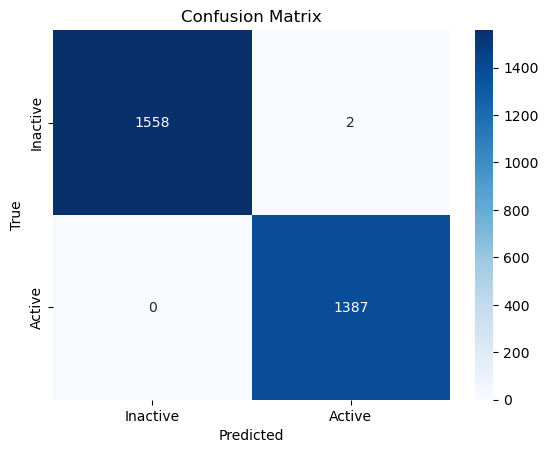

In [30]:
import seaborn as sns

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Inactive", "Active"], yticklabels=["Inactive", "Active"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
